## Intro

In [2]:
import classiq
classiq.authenticate()

/mnt/DOWNLOADS/Physics/Quantum_Computing/WOMANIUM_QM+AI_2024/QC_Programmimg/classiq-qc/classiq-env/lib64/python3.11/site-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [3]:
import numpy as np

# Quantum Walk Operator design for the case of a line with 16 nodes-

First of all, quantum walk is a quantum analogue of RW, in which the state evolution of the quantum walk is defined as a superposition of all possible states. This leads to faster spreading, and hence more intricate interference patterns; this makes quantum walks helpful in quantum algorithms such as search and optimization. They come in two main types: It is worth distinguishing *discrete-time* and *continuous-time* quantum walks.

Secondly, let us construct a sequence of seventeen nodes forming a line such that the nodes are labeled from 0 to fifteen, inclusively. The neighbors of each node are the direct link in the network. A walker at any given node has probability of moving to either the node immediately to its left or right.

*0--1--2--3--4--5...--13--14--15*

In [3]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [4]:
size = 4               # number of qubits to represent 16 vertices
num_nodes = 2**size    # Required Nodes (log_2(16))

The algorithm has two major steps:
- C Operator : it sets the odds of the movements of the walker
- S Operator : establish real movement

## C Operator-

In this case, the C Operator sets up the odds of the walk to move a particular contracting party. The C Operator of the interacting cellular automata changes the state of the walker by assigning amplitudes to shift left or right from the nodes. Similarly, C Operator will determine the chance of a walker at node 0 moving to node 1. The proportions of the walker going to node 14 will be assumed if it is located in node 15. Thus, for nodes in between, the probability is divided equally for movement to the left or to the right.

After that, the diffuser oracle is applied to increase the probability of adjacent nodes.

In [5]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
        prob = [0] * num_nodes
        if i == 0:                  # we can't loop around when we are at the edges of the line
            prob[i + 1] = 1.0       # If at the first node, move to the right node (node 1)
        elif i == num_nodes - 1:
            prob[i - 1] = 1.0       # If at the last node, move to the left node (node 14)
        else:
            prob[i - 1] = 0.5       # Probability of moving to the left node
            prob[i + 1] = 0.5       # Probability of moving to the right node
            print(f'Node={i}, prob vec ={prob}')



        control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

## S Operator-
The next to be used is the S Operator following the computation of the movement probabilities. Dependent on the amplitudes indicated by the C Operator, the C Operator enables the travel in the swapping manner of exchanging the state of the walker from one nodeto the next node. Overall, the shift operator alters the state in case the state of the walker will suggest that the node 14 has been relocated to the two nodes; the node 13 and the node 15. Crucially, this is the stage when quantum interference may happen: chance states or probability coefficients in superimposed affected several routes of transmission by either increasing or decreasing the probability of occurrence of some events.

In [7]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))

@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):                     # Performing the S Operator: move from the current vertex onto the adjecent vertices.
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

The walker is then defined in the superposition of all potential points across the line by carving out the 2 neccessary steps (C op. & S op. ) before the start of the procedure. **The Hadamard gate** which equally distributes the probability for the walker to be caught at any of the 16 nodes is a common quantum gate used to achieve this. The starting state of the walker may be written theoretically in the form of a combination of the basis states |0⟩, |1⟩. .. . **For each of the basis states |15⟩ the corresponded node exists.

# Quantum Operator (Walk)-

In [8]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices)    # Allocating qubits for vertices
    hadamard_transform(vertices)    # Applying Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)    # Again Allocating qubits for adjacent vertices

    C_operator(vertices, adjacent_vertices)  # Applying The C Operator
    S_operator(vertices, adjacent_vertices)  # Applying  The S Operator

In [42]:
# Create and synthesize the quantum walk operator model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=14, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5]
O

This is the initialized circuit -

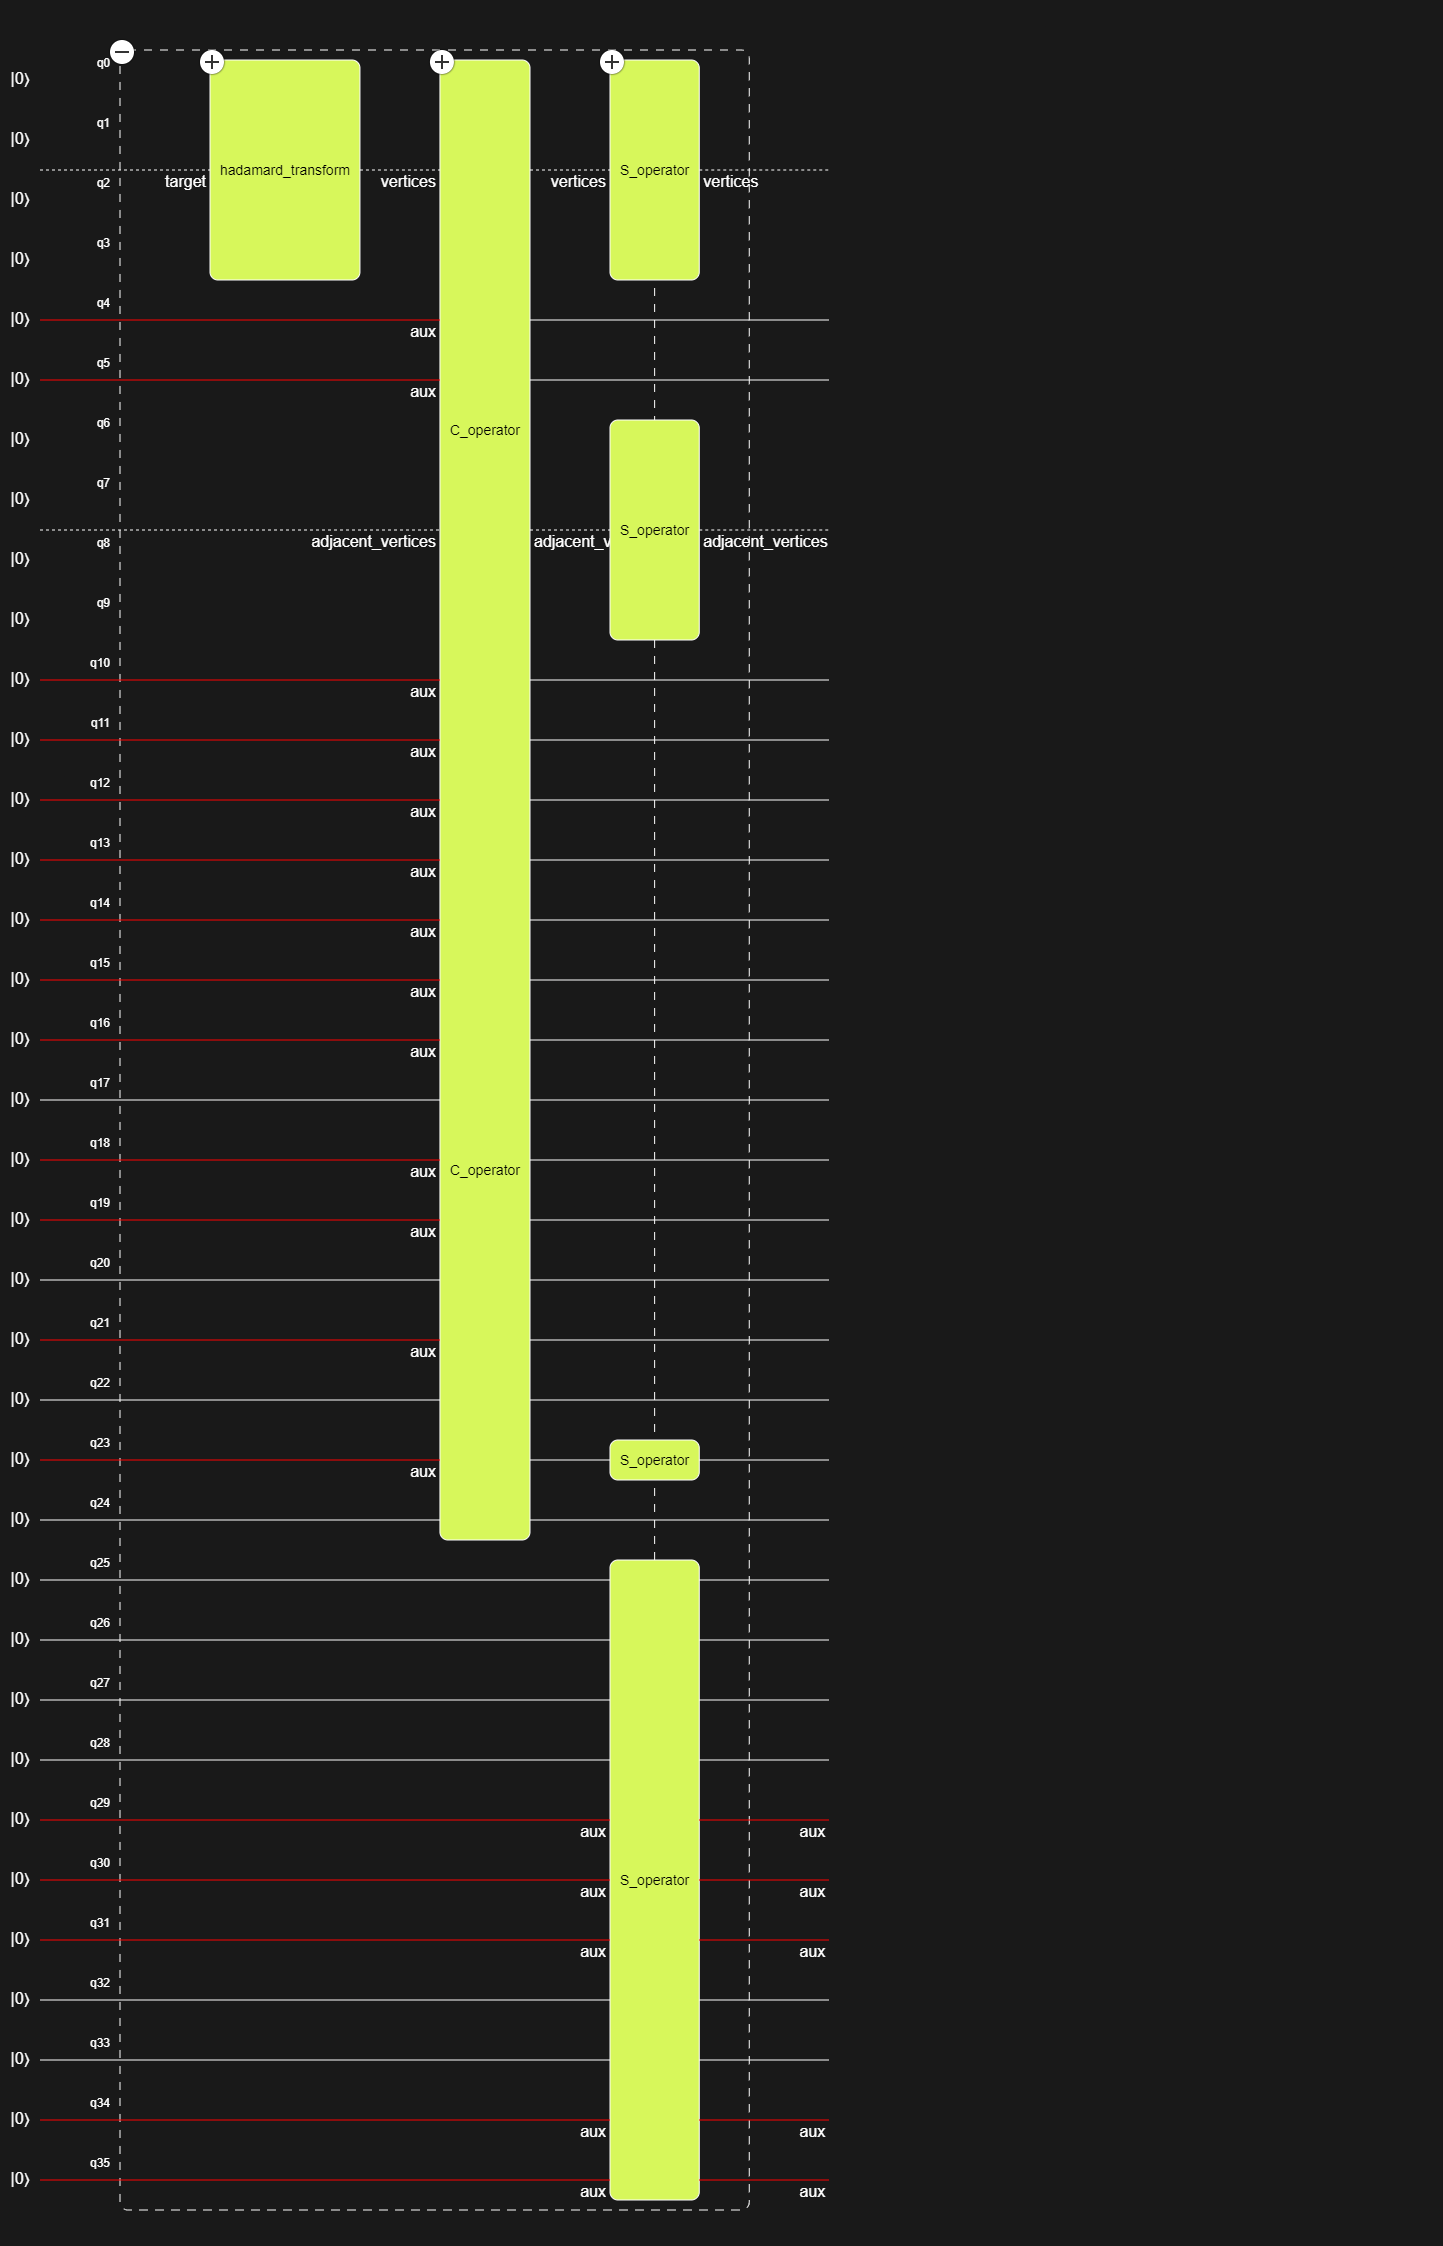

In [56]:
Image('QWC_2.jpg', width = 1000)

If we expand the circuit, we are almost able to achieve the method that we have planned as our goal and objective.

The following are some of the C & S operators screenshots to enable everyone to have an insight on the way they operate Icon a.

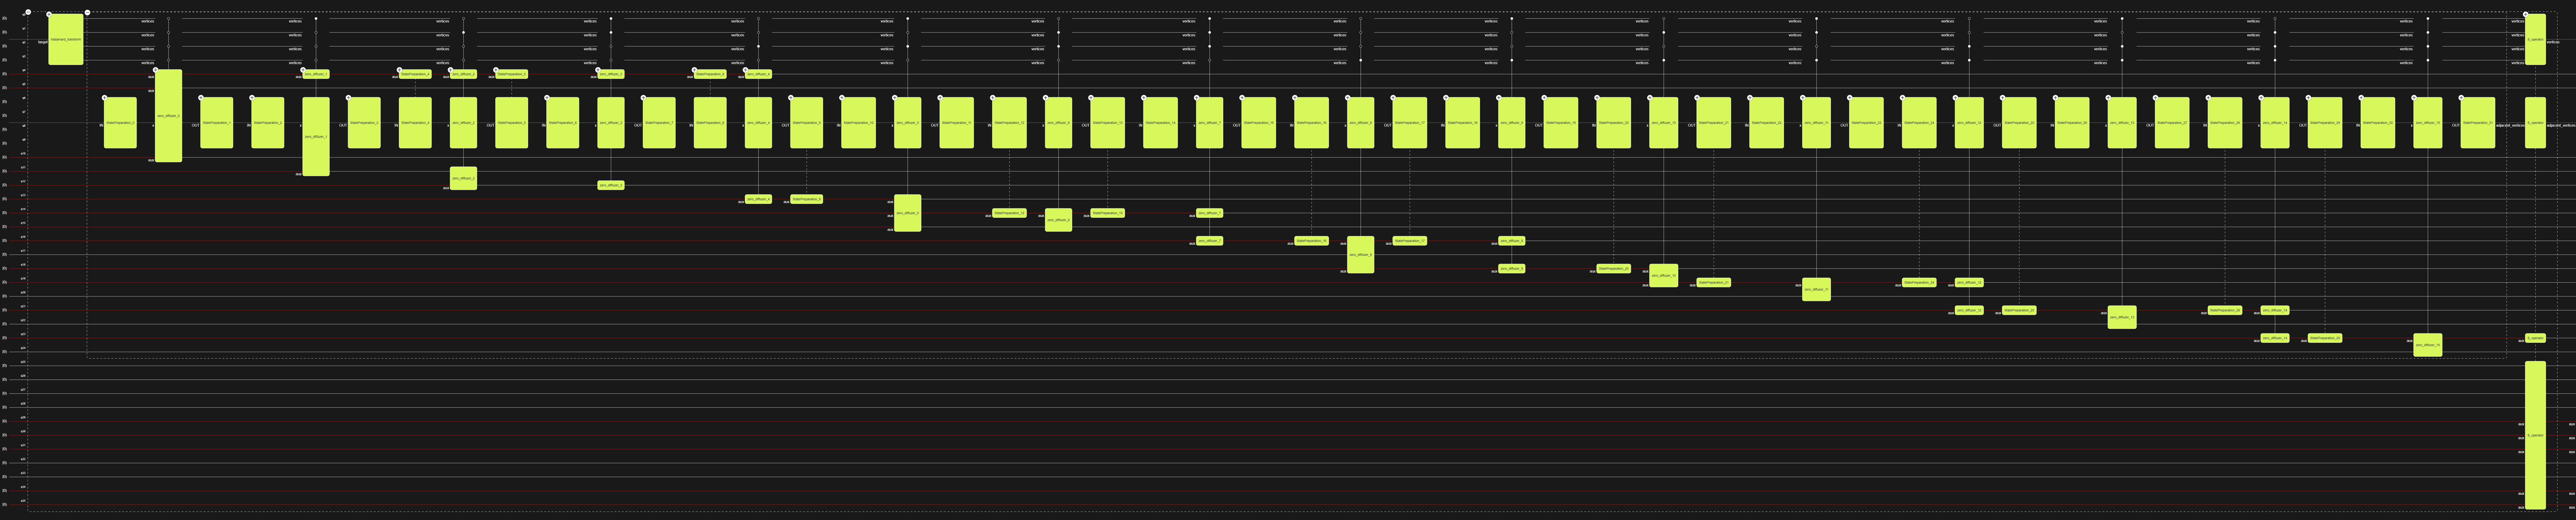

In [62]:
Image('C Op.jpg', width = 10000)

Quantum Walk Apply the C Operator

Next, we see that Hadamard gates are applied at the start of the circuit to create an even superposition over all possible states. This gives the walker a nonzero chance of being at any one out of 16 nodes. The state preparation block assigns the probabilities for walker to go to next nodes by compute probability amplitudes. The zero diffuser block now enforces that each of these probabilities are properly allocated, with the help of an auxiliary qubit (aux) using diffusion operator.Each node undergoes these operations sequentially.

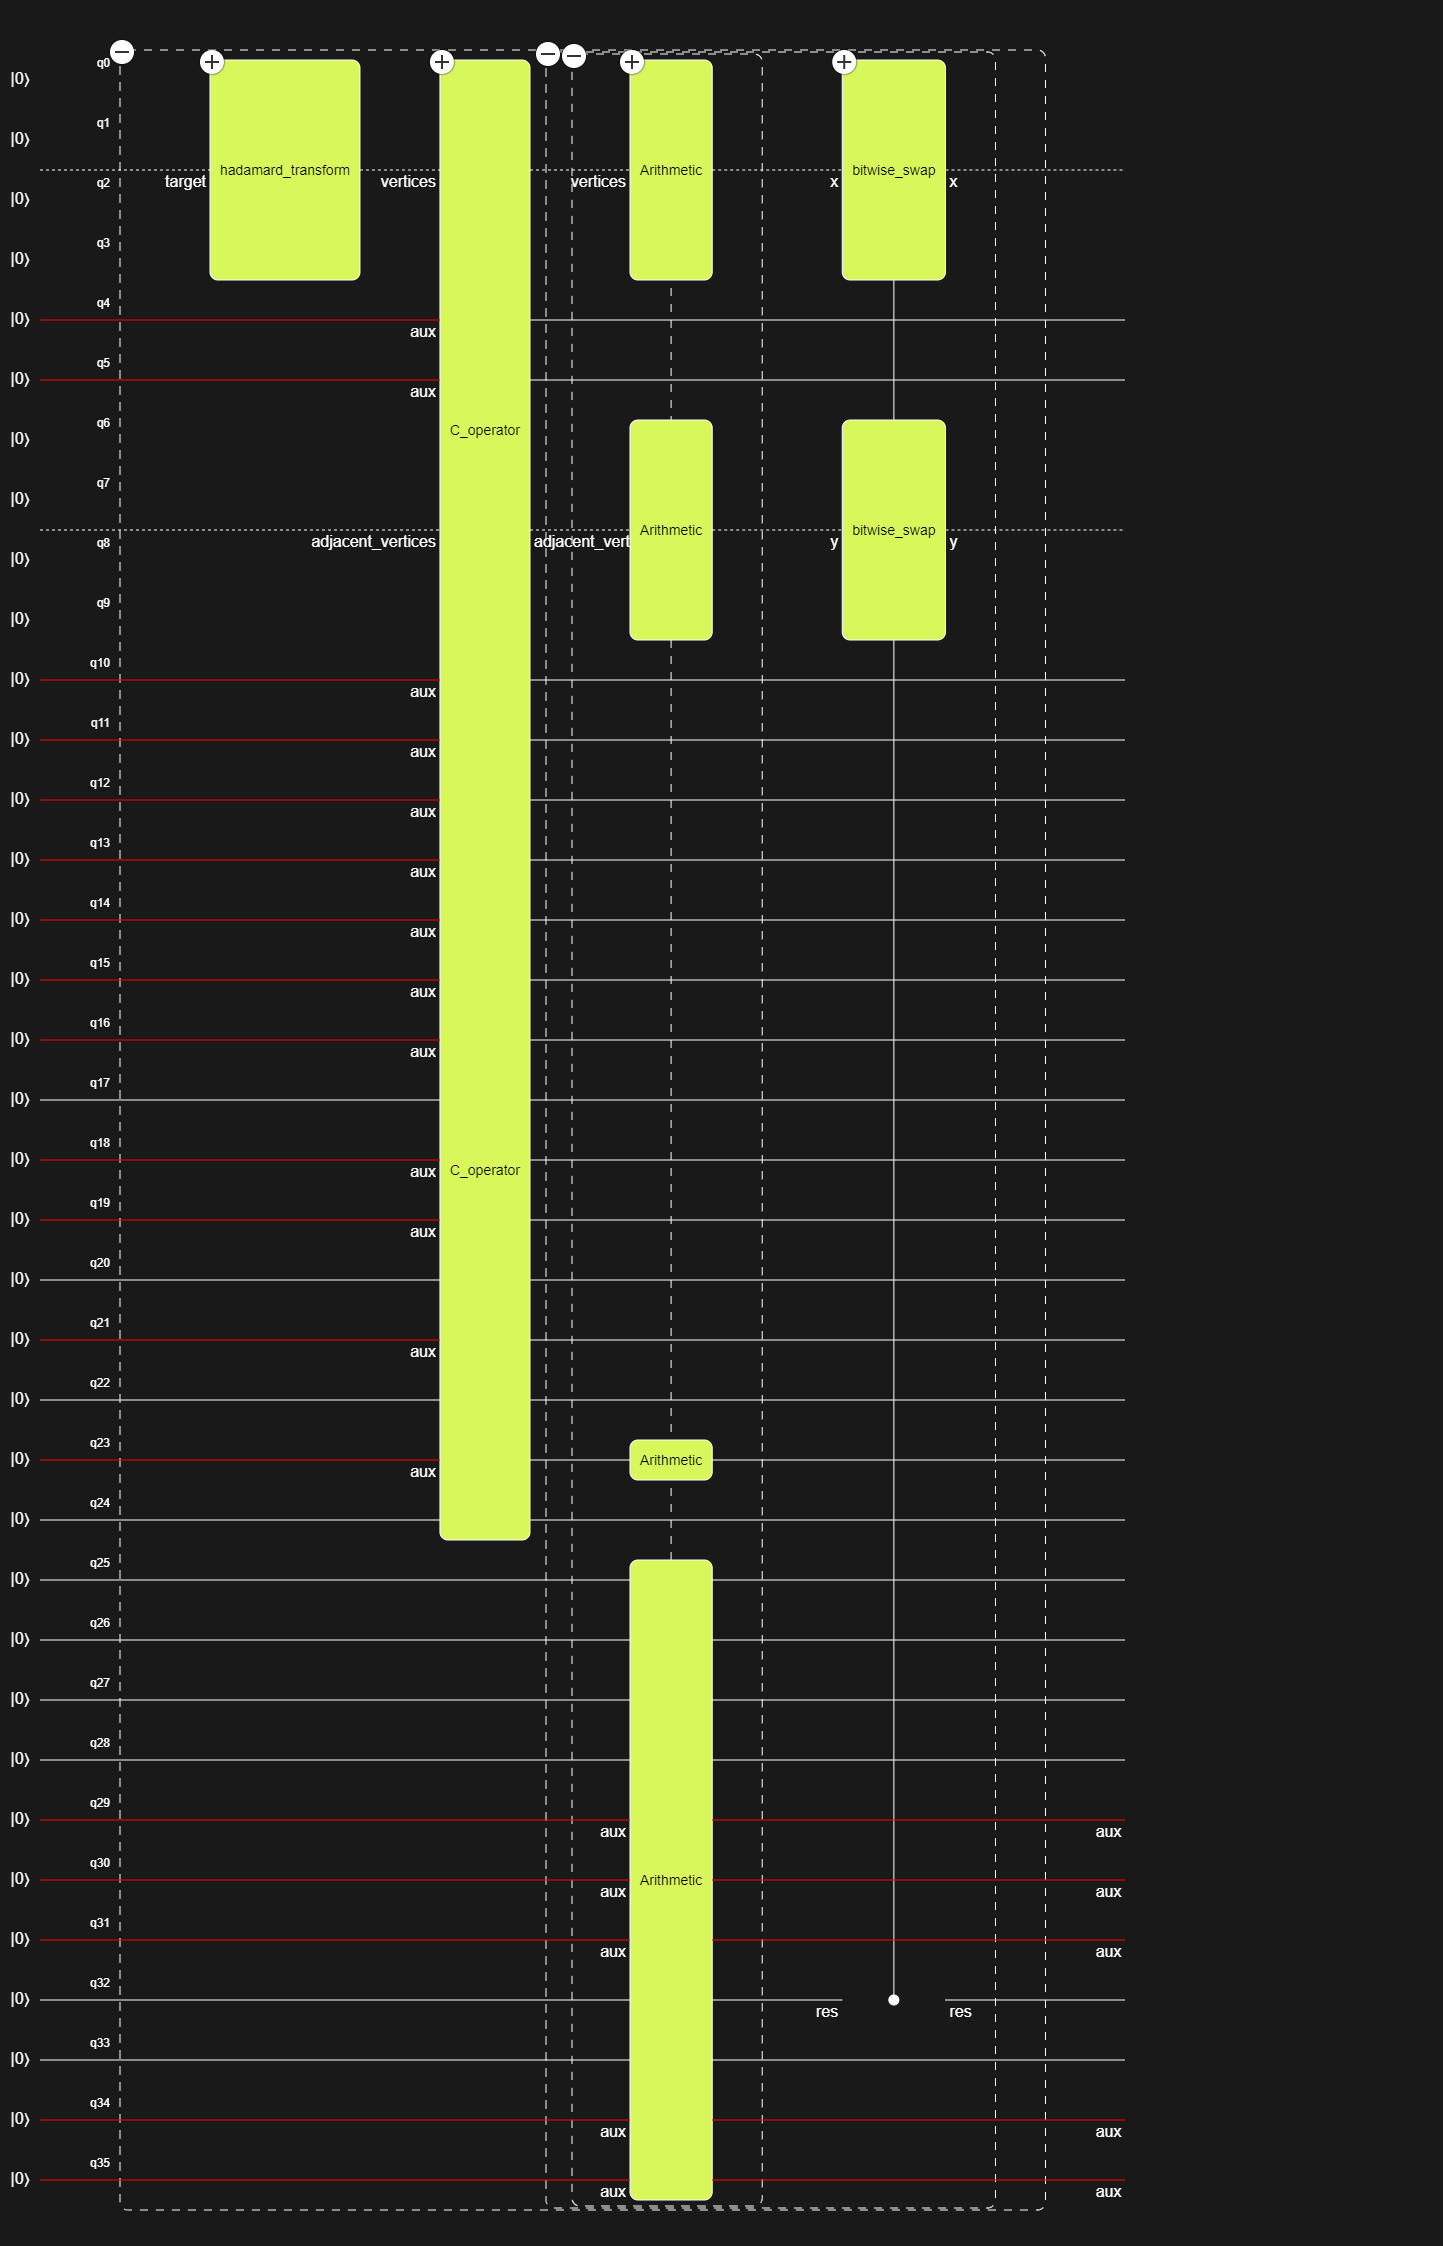

In [67]:
Image('S_Op.jpg', width = 1000)

Here is an example of how S Operator gets used in code

The Edge Oracle Block is checking to see if the current vertex we are looking at connects with an adjacent vertex and will set a Flag Qubit (a marker, or signal). If they are next to each other a bitwise swap allows the walker to move one place over in that linked vertex.